In [61]:
import pandas as pd

#Tratando os dados
url = "DAT_ASCII_EURJPY_M1_2018.csv"
df = pd.read_csv(url, delimiter = ';', 
                 header = None, 
                 names = ["Data", "Open", "High", "Low", "Close", "Volume"], 
                 parse_dates = ["Data"])

df.set_index("Data", inplace = True) 
df.index.names = [None]
df = df.drop("Volume", axis=1)                                                    
df.index = df.index.tz_localize('EST').tz_convert('Brazil/West').tz_localize(None)

#Transformando 1min em 5min
df_ohlc = df.resample('5Min').agg({'Open': 'first', 
                                 'High': 'max', 
                                 'Low': 'min', 
                                 'Close': 'last'})

#Calculando media móvel exponencial(100 períodos) e fator de inclinação (positivo/negativo)

df_ohlc['EMA100'] = df_ohlc['Close'].ewm(span = 100, adjust = False, min_periods = 100).mean()

df_ohlc.loc[(df_ohlc.EMA100 > df_ohlc.EMA100.shift(1)), 'AC'] = 1
df_ohlc.loc[(df_ohlc.EMA100 < df_ohlc.EMA100.shift(1)), 'AC'] = -1
df_ohlc.loc[(df_ohlc.EMA100 == df_ohlc.EMA100.shift(1)), 'AC'] = 0

#Calculando Banda de Bollinger (20 períodos (p), 2.5 std(std))
p = 20
std = 2.5
bbsma = f'SMA{p}'
bbs = f'BS{p}'
bbi = f'BI{p}'
df_ohlc[bbsma] = df_ohlc['Close'].rolling(p).mean()
df_ohlc[bbs] = df_ohlc[bbsma] + (std * df_ohlc['Close'].rolling(p).std())
df_ohlc[bbi] = df_ohlc[bbsma] - (std * df_ohlc['Close'].rolling(p).std())

#Condicionando o setup de entrada

df_ohlc['Result'] = 0

#TruePositive
df_ohlc.loc[((df_ohlc.AC.shift(1) == 1) 
             & (df_ohlc.Low < df_ohlc[bbi]) 
             & (df_ohlc.Close > df_ohlc[bbi]) 
             & (df_ohlc.Open > df_ohlc[bbi])), 'Result'] = 1

#TrueNegative
df_ohlc.loc[((df_ohlc.AC.shift(1) == -1) 
             & (df_ohlc.High > df_ohlc[bbs]) 
             & (df_ohlc.Close < df_ohlc[bbs]) 
             & (df_ohlc.Open < df_ohlc[bbs])), 'Result'] = 1

#FalsePositive
df_ohlc.loc[((df_ohlc.AC.shift(1) == 1) 
             & (df_ohlc.Low < df_ohlc[bbi]) 
             & (df_ohlc.Close <= df_ohlc[bbi]) 
             & (df_ohlc.Open > df_ohlc[bbi])), 'Result'] = -1

#FalseNegative
df_ohlc.loc[((df_ohlc.AC.shift(1) == -1) 
             & (df_ohlc.High > df_ohlc[bbs]) 
             & (df_ohlc.Close >= df_ohlc[bbs]) 
             & (df_ohlc.Open < df_ohlc[bbs])), 'Result'] = -1


#Calculando Winrate

df_ohlc = df_ohlc[100:]
df_ohlc


,Open,High,Low,Close,EMA100,AC,SMA20,BS20,BI20,Result
2018-01-02 02:20:00,135.510,135.514,135.497,135.502,135.412285,1.0,135.48385,135.541073,135.426627,0
2018-01-02 02:25:00,135.503,135.504,135.476,135.492,135.413864,1.0,135.48615,135.538973,135.433327,0
2018-01-02 02:30:00,135.491,135.491,135.474,135.483,135.415233,1.0,135.48745,135.537479,135.437421,0
2018-01-02 02:35:00,135.483,135.520,135.480,135.511,135.417129,1.0,135.49050,135.537006,135.443994,0
2018-01-02 02:40:00,135.512,135.531,135.510,135.522,135.419206,1.0,135.49390,135.538340,135.449460,0
2018-01-02 02:45:00,135.523,135.524,135.482,135.513,135.421063,1.0,135.49705,135.534409,135.459691,0
2018-01-02 02:50:00,135.514,135.527,135.498,135.502,135.422666,1.0,135.49805,135.534419,135.461681,0
2018-01-02 02:55:00,135.504,135.554,135.502,135.526,135.424712,1.0,135.50100,135.535717,135.466283,0
2018-01-02 03:00:00,135.526,135.559,135.500,135.517,135.426540,1.0,135.50240,135.537460,135.467340,0
2018-01-02 03:05:00,135.521,135.536,135.499,135.500,135.427994,1.0,135.50280,135.537361,135.468239,0


In [4]:
# #Plotando gráfico de candlesticks (https://youtu.be/19yyasfGLhk?t=318)
# def plot_p(df):
#     import matplotlib.pyplot as plt
#     from mpl_finance import candlestick2_ohlc
#     fig, ax = plt.subplots(figsize=(20, 10))
#     candlestick2_ohlc(ax,
#                       df_ohlc['Open'].values,
#                       df_ohlc['High'].values,
#                       df_ohlc['Low'].values,
#                       df_ohlc['Close'].values,
#                       width = 0.6,
#                       colorup = 'g',
#                       colordown = 'r',
#                       alpha = 1, )
#     plt.show()
    
# plot_p(df_ohlc[:300])

In [5]:
import matplotlib.pyplot as plt
num = 2000
plt.figure(figsize = (15,10))
plt.grid(True)
plt.plot(df_ohlc['Close'][:num], label = 'Close')
plt.plot(df_ohlc[bbsma][:num], label = bbsma)
plt.plot(df_ohlc['EMA100'][:num], label = 'EMA100')
plt.legend(loc = 2)

C:\Users\r_mar\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


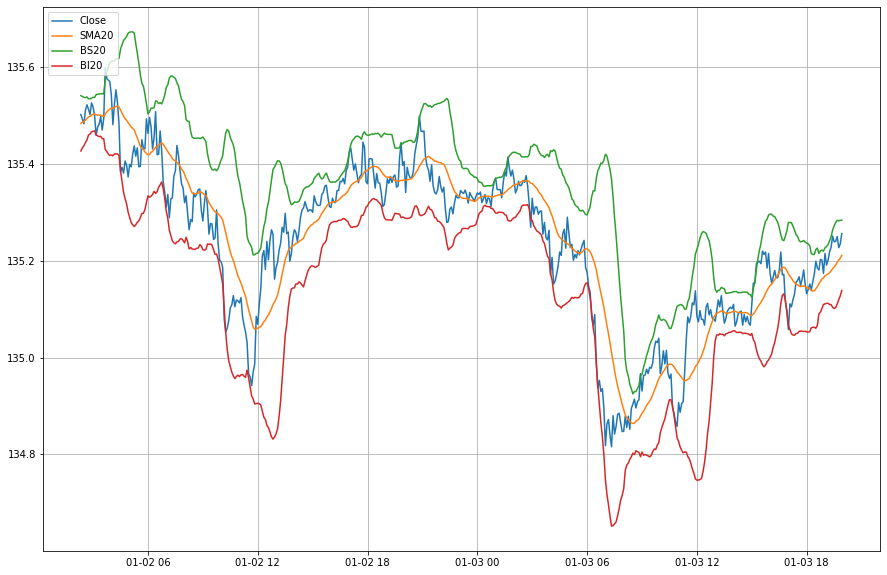

In [6]:
import matplotlib.pyplot as plt
num = 500
plt.figure(figsize = (15,10))
plt.grid(True)
plt.plot(df_ohlc['Close'][:num], label = 'Close')
plt.plot(df_ohlc[bbsma][:num], label = bbsma)
plt.plot(df_ohlc[bbs][:num], label = bbs)
plt.plot(df_ohlc[bbi][:num], label = bbi)
plt.legend(loc = 2)